# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.metrics

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils

torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
data_train = train_dataset.data/255
data_test = test_dataset.data/255

# dictionary with means and standard deviations
dict = {'Mean (Train)': list(data_train.mean(axis = (0,1,2))),
        'Mean (Test)': list(data_test.mean(axis = (0,1,2))),
        'Standard deviation (Train)': list(data_train.std(axis = (0,1,2))),
        'Standard deviation (Test)': list(data_test.std(axis = (0,1,2)))}

# dictionary to dataframe
df = pd.DataFrame(data=dict)

# show dataframe
display(df)

# Size of sets
print(f'Shape of training set: {train_dataset.data.shape}') # images, height, width, color channels
print(f'Shape of test set:     {test_dataset.data.shape}')  # 10000 images, 32px, 32px, 3 color channels (RGB)

100%|██████████| 170498071/170498071 [00:03<00:00, 50676300.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


,Mean (Train),Mean (Test),Standard deviation (Train),Standard deviation (Test)
0,0.491400,0.494214,0.247032,0.246653
1,0.482158,0.485131,0.243485,0.242892
2,0.446531,0.450409,0.261588,0.261592


Shape of training set: (50000, 32, 32, 3)
Shape of test set:     (10000, 32, 32, 3)


In [5]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=batch_size) 

In [6]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    images, labels = next(iter(dl))

    # Create a grid of normalized images
    grid = utils.make_grid(images, nrow=16, padding=12, normalize=True)

    # Transpose the grid (color channels should be in the last position)
    grid = np.transpose(grid, (1, 2, 0))
    
    # Define class labels
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Plot the grid of images
    plt.figure(figsize=(16, 16)) # 16 * 16 = 256
    plt.imshow(grid)
    plt.axis('off')

    # Define label position offsets
    x_offset = 28
    y_offset = 51  # Fixed vertical offset below the grid

    # Display the labels below each image
    for i in range(256):
        x = i % 16 * 44 + x_offset
        y = (i // 16) * 44 + y_offset
        plt.text(x, y, class_labels[labels[i]], color='white', backgroundcolor='black', fontsize=8, ha='center')
        
    plt.show()

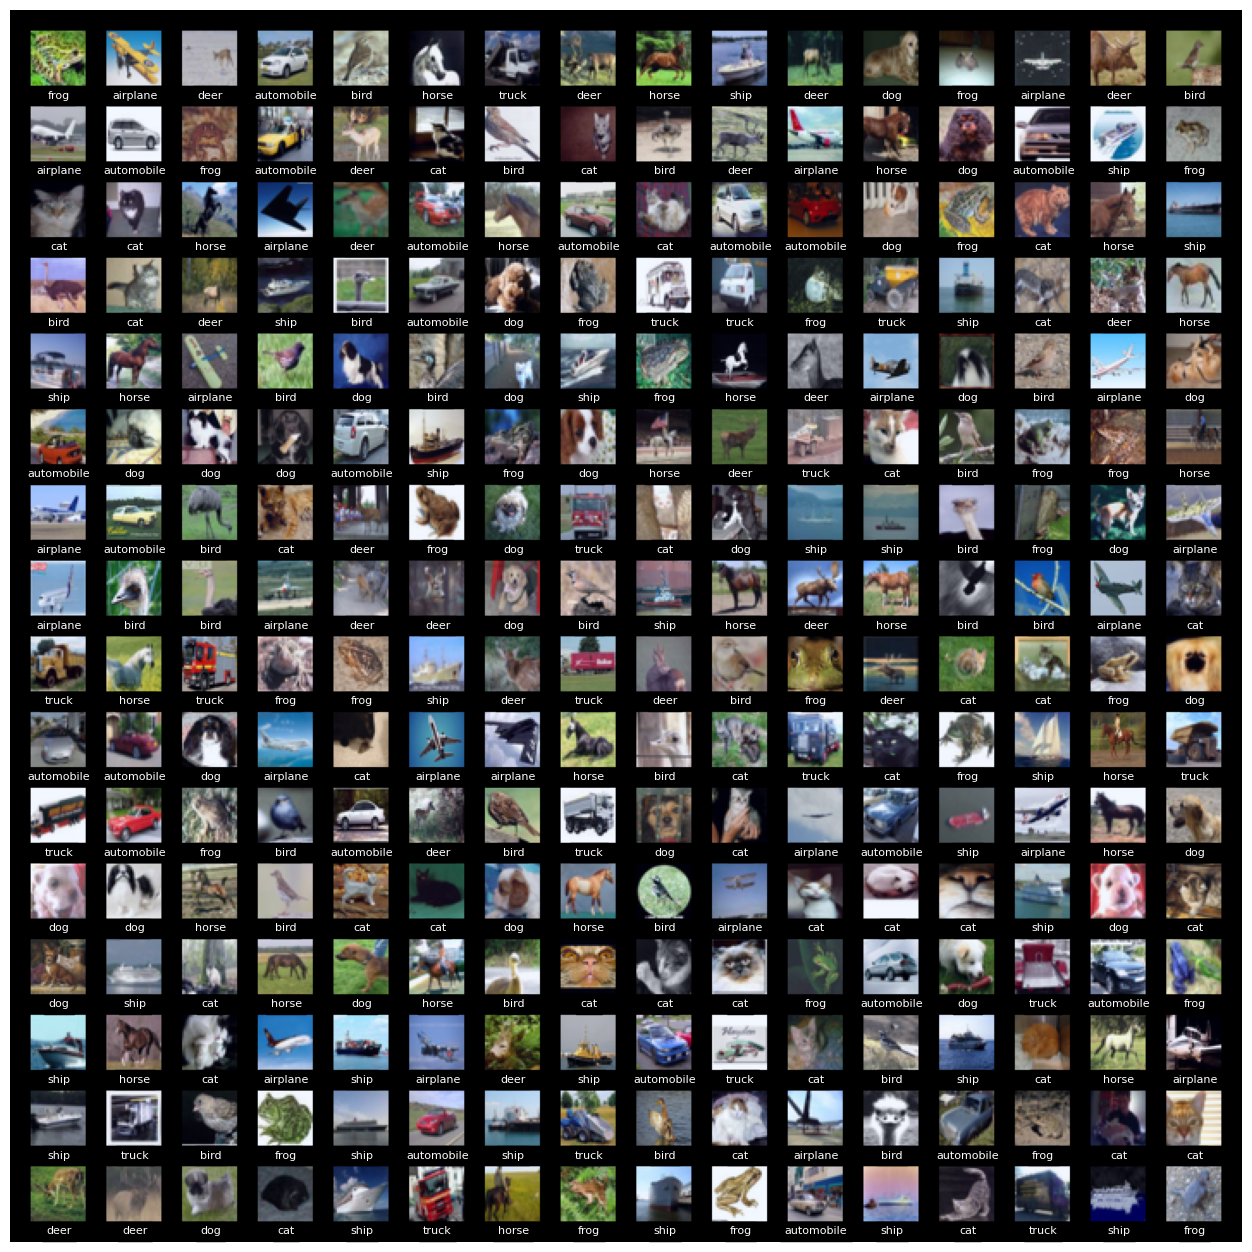

In [7]:
show_batch(train_loader)

In [8]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [9]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct/total

    return ratio

In [10]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device):
    """Method to train the model"""

  # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy

    model.train()  
    train_loss = 0.0
    correct = 0
    total = 0
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model.forward(x)
        
        loss = loss_fn(y_pred.squeeze(), y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_loss /= len(dataloader)
    train_accuracy = accuracy(correct, total)
    
    return train_loss, train_accuracy


def validate(val_dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (x_val, y_val) in enumerate(val_dataloader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred_val = model(x_val)
            loss_val = loss_fn(y_pred_val.squeeze(), y_val)

            val_loss += loss_val.item()

            _, predicted_val = torch.max(y_pred_val.data, 1)
            total += y_val.size(0)
            correct += (predicted_val == y_val).sum().item()

        val_loss /= len(val_dataloader)
        val_accuracy = accuracy(correct, total)
    
    return val_loss, val_accuracy



In [11]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, test_dataloader):
    """Method to run the training procedure"""
  # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

    train_losses = []  # Array to store training losses for each epoch
    val_losses = []  # Array to store validation losses for each epoch
    train_accs = []  # Array to store training accuracies for each epoch
    val_accs = []  # Array to store validation accuracies for each epoch

    for epoch in trange(num_epochs, desc='Epoch'):
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_accuracy = validate(test_dataloader, model, loss_function, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs

In [12]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predicted.cpu().numpy().tolist())

    confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    return confusion    

## Logistic Regression   

Should this say linear regression ? Why should 

In [13]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)
        
        # TODO: run the data through the layer
        outputs = self.linear(x)
        
        return outputs

In [14]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(32*32*3, num_classes)    # Instantiate model with input dimension, output dimension
linear_regression.to(device)                    # Move the model to the GPU
linear_regression.train()                       # Set the model to train mode

LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [15]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [16]:
# TODO: define the loss function
loss_fn = nn.CrossEntropyLoss()

In [17]:
num_epochs = 20
## TODO: run training over 20 epochs
lr_stats = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [04:37<00:00, 13.87s/it]


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [18]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super().__init__()

        # Initiate 4 fully connected layers (fc)
        self.fc1 = torch.nn.Linear(input_dim, 1650)
        self.fc2 = torch.nn.Linear(1650, 512)
        self.fc3 = torch.nn.Linear(512, 138)
        self.fc4 = torch.nn.Linear(138, output_dim)
        
        self.relu = torch.nn.ReLU()
        
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input

        xb = xb.view(xb.size(0), -1)  # Flatten the input
        
        out = self.fc1(xb)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        
        return out

In [19]:
## TODO: Define network, put it to device and train mode
input_dim = 32*32*3
output_dim = num_classes

mlp = MLP(input_dim, output_dim)    
mlp.to(device)                    
mlp.train()                       

MLP(
  (fc1): Linear(in_features=3072, out_features=1650, bias=True)
  (fc2): Linear(in_features=1650, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=138, bias=True)
  (fc4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [20]:
## TODO: Define optimizer and loss functions

# Define the optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
mlp_stats = run_training(mlp, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [04:38<00:00, 13.91s/it]


## Add L2 regularisation

In [22]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
mlp_L2 = MLP(input_dim, output_dim)    
mlp_L2.to(device)                    
mlp_L2.train()  

# Initiate new optimizer with weight decay
optimizer = torch.optim.Adam(mlp_L2.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [23]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
mlp_L2_stats = run_training(mlp_L2, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [04:41<00:00, 14.09s/it]


## LeNet5

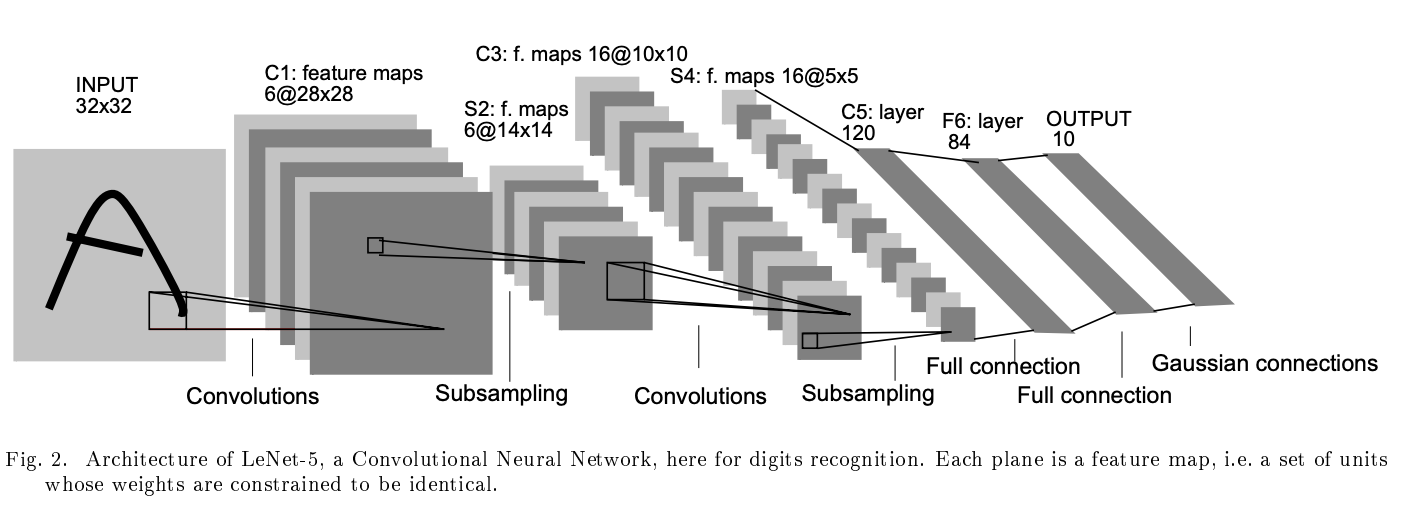

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [24]:
class LeNet5(nn.Module):
    # Change default channels to 3 since we have RGB and not grey scale
    def __init__(self, n_classes, in_channels=3):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            # Connect the flattened feature maps from previous layers to fully connected layer
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [25]:
## TODO: define network, put it to the device and train mode
LeNet_5 = LeNet5(num_classes)
LeNet_5.to(device)                    
LeNet_5.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [26]:
## TODO: define loss function and optimisers
optimizer = torch.optim.Adam(LeNet_5.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [27]:
## TODO: train with 20 epochs
num_epochs = 20
LeNet_5_stats = run_training(LeNet_5, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [04:48<00:00, 14.43s/it]


## Analysis 

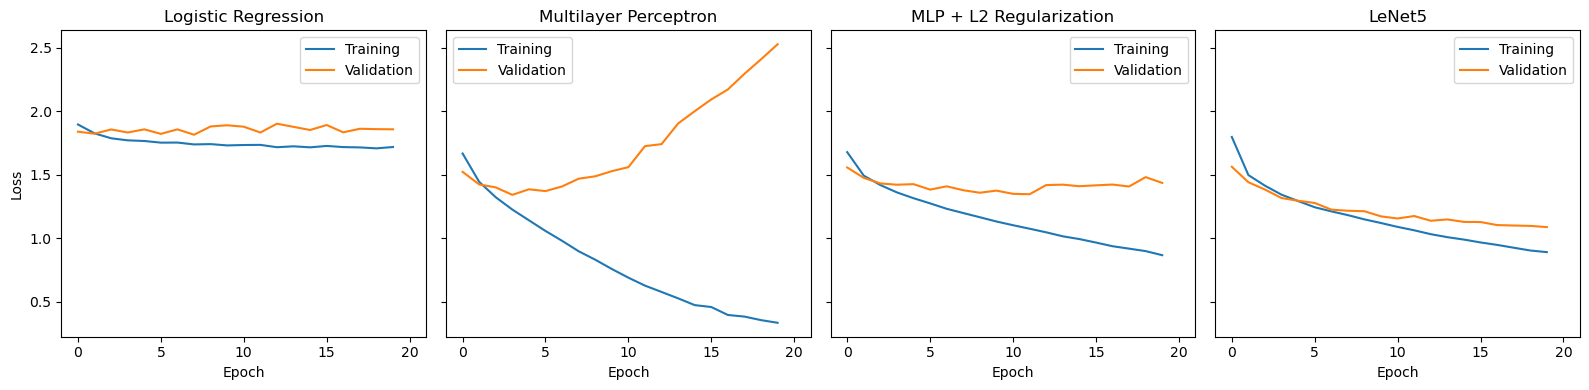

In [28]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

axs[0].set_ylabel("Loss")
axs[0].set_title("Logistic Regression")
axs[0].plot(lr_stats[0], label="Training")
axs[0].plot(lr_stats[1], label="Validation")

axs[0].set_ylabel("Loss")
axs[1].set_title("Multilayer Perceptron")
axs[1].plot(mlp_stats[0], label="Training")
axs[1].plot(mlp_stats[1], label="Validation")

axs[0].set_ylabel("Loss")
axs[2].set_title("MLP + L2 Regularization")
axs[2].plot(mlp_L2_stats[0], label="Training")
axs[2].plot(mlp_L2_stats[1], label="Validation")

axs[0].set_ylabel("Loss")
axs[3].set_title("LeNet5")
axs[3].plot(LeNet_5_stats[0], label="Training")
axs[3].plot(LeNet_5_stats[1], label="Validation")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])
    ax.legend()

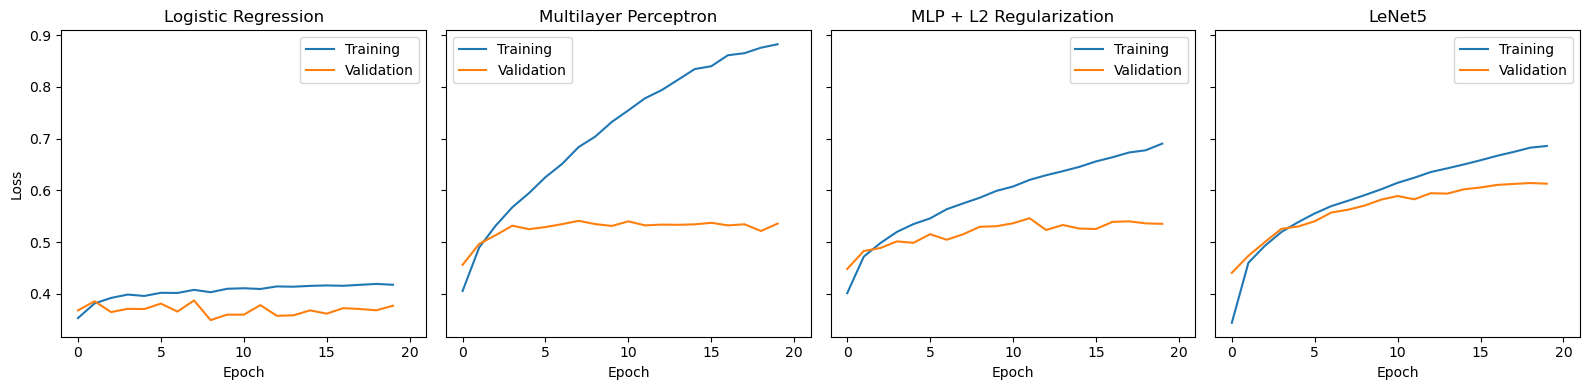

In [29]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

axs[0].set_ylabel("Loss")
axs[0].set_title("Logistic Regression")
axs[0].plot(lr_stats[2], label="Training")
axs[0].plot(lr_stats[3], label="Validation")

axs[0].set_ylabel("Loss")
axs[1].set_title("Multilayer Perceptron")
axs[1].plot(mlp_stats[2], label="Training")
axs[1].plot(mlp_stats[3], label="Validation")

axs[0].set_ylabel("Loss")
axs[2].set_title("MLP + L2 Regularization")
axs[2].plot(mlp_L2_stats[2], label="Training")
axs[2].plot(mlp_L2_stats[3], label="Validation")

axs[0].set_ylabel("Loss")
axs[3].set_title("LeNet5")
axs[3].plot(LeNet_5_stats[2], label="Training")
axs[3].plot(LeNet_5_stats[3], label="Validation")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])
    ax.legend()

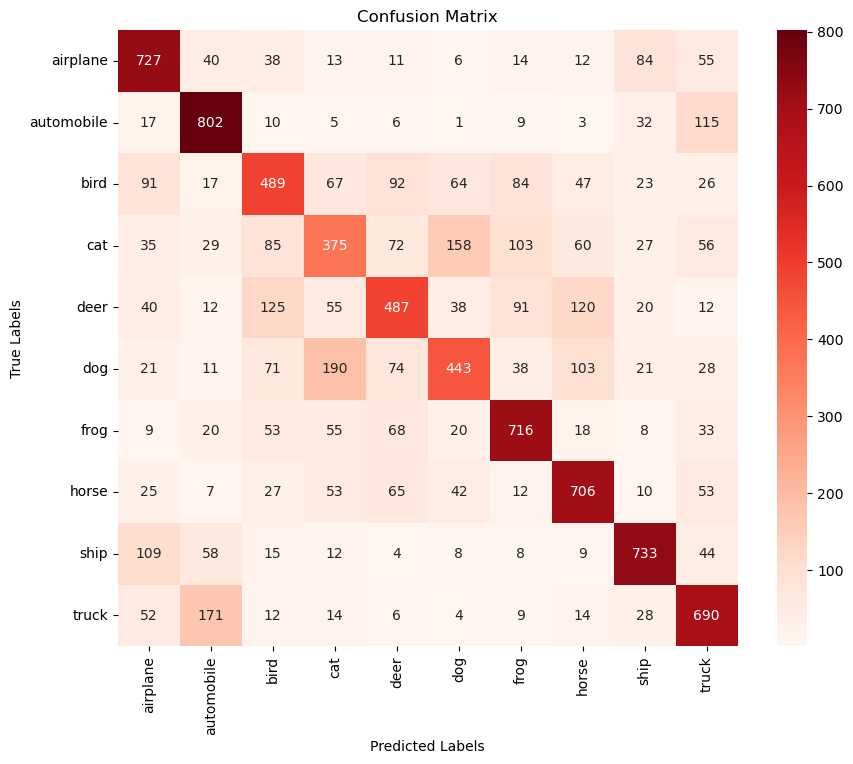

In [30]:
## TODO: Plot the confusion matrix for LeNet5
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
confusion_matrix = calc_confusion_values(test_loader, LeNet_5, device)

# Define class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Confusion matrix with shares of true/false identification
print(confusion_matrix)


[[727  40  38  13  11   6  14  12  84  55]
 [ 17 802  10   5   6   1   9   3  32 115]
 [ 91  17 489  67  92  64  84  47  23  26]
 [ 35  29  85 375  72 158 103  60  27  56]
 [ 40  12 125  55 487  38  91 120  20  12]
 [ 21  11  71 190  74 443  38 103  21  28]
 [  9  20  53  55  68  20 716  18   8  33]
 [ 25   7  27  53  65  42  12 706  10  53]
 [109  58  15  12   4   8   8   9 733  44]
 [ 52 171  12  14   6   4   9  14  28 690]]


## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
